# Coarse-Graining: Progress through April 3, 2019

## Two (visible) spins, coupled to a single hidden unit:

\begin{equation}
P\left(s_1,s_2,\sigma\right) = \frac{1}{Z} e^{(J_0 + J_1 s_1 + J_2 s_2)\sigma}; \mbox{  } \lbrace s_1, s_2, \sigma \rbrace=\lbrace \pm 1 \rbrace
\end{equation}


1st- and 2nd-order statistics in terms of couplings:
\begin{align*}
    \langle s_1 \rangle &= \tanh{(J_0)}\tanh{(J_1)}  \\    
    \langle s_2 \rangle &= \tanh{(J_0)}\tanh{(J_2)}  \\
    \langle s_1 s_2 \rangle &= \tanh{(J_1)}\tanh{(J_2)} 
\end{align*}

Invert to solve for couplings:
\begin{align*}
    J_0 &= \pm \tanh^{-1}{\sqrt{\frac{\langle s_1 \rangle \langle s_1 \rangle}{\langle s_1 s_2 \rangle}}} \\   
    J_1 &= \pm \tanh^{-1}{\sqrt{\frac{\langle s_1 \rangle \langle s_1 s_2 \rangle}{\langle s_2 \rangle}}}  \\ 
    J_2 &= \pm \tanh^{-1}{\sqrt{\frac{\langle s_2 \rangle \langle s_1 s_2 \rangle}{\langle s_1 \rangle}}}
\end{align*}


### Solutions are contingent on sign consistency.
While $\langle s_1 \rangle$ and $\langle s_1 \rangle$ will be negative in a neuroscience context, having $\langle s_1s_2 \rangle<0$ simultaneously is problematic.


### Are we assured that $\langle s_1 s_2 \rangle >0$?


Consider two binary random variables $x$ and $y$. Let

\begin{align*}
    P(x=1) &= p  \\
    P(y=1) &= q   \\
    P(x=1, y=1) &= r
\end{align*}

so that 

\begin{align*}
    \langle x \rangle &= (-1)P(x=-1) + (1)P(x=1) = (1-p) + p = 2p-1 \\  
   \langle y \rangle &= (-1)P(y=-1) + (1)P(y=1) = (1-q) + q = 2q-1;
\end{align*}

then we can write the expectation of $x \cdot y$ (pairwise corelation)

\begin{align*}
    \langle xy \rangle &= (-1)\left(P(x=1,y=-1) + P(x=-1,y=1)\right) + (1)\left(P(x=1,y=1)+ P(x=-1,y=-1)\right) \\
     &= (-1)\left((p-r) + (q-r)\right) + (1)\left((r)+ (1-p-q+r)\right) \\
     &= -\left(p + q -2r)\right) + \left(1-p-q+2r\right) \\
     &= 4r-2p-2q+1.
\end{align*}


Since we want $\langle xy \rangle >0$, we have

\begin{align*}
    4r-2p-2q+1 &> 0 \\
    4r &> 2p+2q-1 \\
    r &> \frac{p+q}{2} - \frac{1}{4}.
\end{align*}

That is, the parameter $r$ must be greater than the average of $p$ and $q$, minus $\frac{1}{4}$. Let $x \rightarrow s_1$ and $y \rightarrow s_2$.

In typical neuroscience applications, both parameters $p$ and $q <<0.25$ because neurons fire very sparsely.

Thus in order for $\langle s_1 s_2 \rangle >0$, we only need r to be greater than a negative number.

But this is always true for $\frac{p+q}{2}<=\frac{1}{4}$, because as a probability $r>0$ by definition.

QED

## So, the signs are consistent?

It would appear to be so; choosing the negative value for $J_0$ will result in ...

## 1. Prepare the data

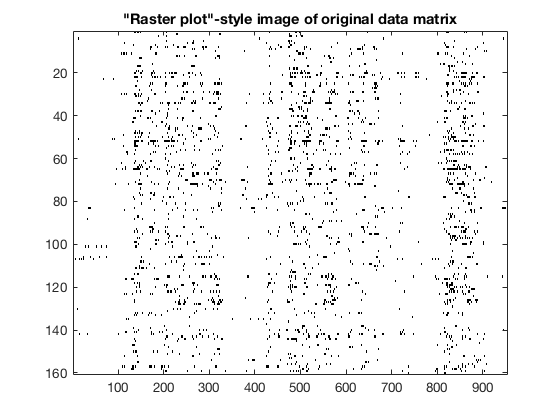

In [1]:
%CGpipeline
%close all; clear; clc; CGpipeline

 
%Load neural data
load bint_fishmovie32_100
data=reshape(bint(297,:,:),[160,953]);
data=data*2-1;
mean(sum(data>0,2)/953);  %Check the value of "p", how many times spiking
mean(mean(data,2));       %Check the value of <x>, the average firing rate


%CHOOSE THE NUMBER OF CG ITERATIONS !
%Number of times to apply above transformation
% Pre-allocate space for saving each GC step
CGevents=5;            %Number of iterations
C{1,CGevents+1}=[];    %Empty cell array to contain the coarsened data matrix at each step
C{1}=data;             %First element of cell array (i.e., 1st cell)--> original data matrix


%Begin a new cell array containing the "included" neuron trajectories (which will change)
for g=1:size(C{1},1)
  c{g}=C{1}(g,:);       %Break down each neuron's trajectory as member in a small cell array
end
D{1}=c;                 %Bigger cell array whose first element is "c", keeps track over iterations
%masterlist{1}=c;



%"Raster plot"-style image of original data matrix
figure,imagesc(C{1})
colormap(flipud(gray))
title('"Raster plot"-style image of original data matrix')


## 2. Perform the CG using analytical solution, for $CGevents$ iterations

In [2]:

%Main loop

for k=1:CGevents
k

 
%Find most highly correlated pair
[mosthigh,hival]=find_most_highly(data);
MostHi(k,:)=mosthigh;

%Calculate stats for most highly correlated pair
v1=data(mosthigh(1),:); v2=data(mosthigh(2),:);
means=[mean(data(mosthigh(1),:)) mean(data(mosthigh(2),:))];
pairwise=mean(data(mosthigh(1),:).*data(mosthigh(2),:));
covarnce=pairwise-mean(data(mosthigh(1),:))*mean(data(mosthigh(2),:));

%Break the loop if <s_1*s_2> is negative or zero
if pairwise<=0
    fprintf('Non-positive pairwise correlation')
    k
    break   %Violates assumptions; stop here
end


%Analytical solution equations
tanhJ0sqd=means(1)*means(2)/pairwise;
tanhJ1sqd=means(1)*pairwise/means(2);
tanhJ2sqd=means(2)*pairwise/means(1);

 
%Break the loop if any of above is >1
if sum([tanhJ0sqd tanhJ1sqd tanhJ2sqd]>1)
    fprintf('Error: Component > 1')
    k
    break
end

%Choose values of couplings (interdependent, from each other)
J0=atanh(-tanhJ0sqd^.5);       %choose minus root as default
%J1=atanh(tanhJ1sqd^.5);
J1=atanh(means(1)/tanh(J0));
%J2=atanh(tanhJ2sqd^.5);
J2=atanh(pairwise/tanh(J1));
%mean(v1)^2+mean(v2)^2

%Correlation for current pair -- check
corry=(pairwise-mean(v1)*mean(v2))/sqrt(var(v1)*var(v2));
[J0 J1 J2]

%In case any of above didn't catch it...
if sum((imag([J0 J1 J2]))~=0)
    fprintf('Imaginary couplings')
    k
    break

end

%Propagate once, forward and backward
logistic_through         %Calculate sigma (hidden) from v1,v2; then in reverse
Meansig(k)=meansig;
data(mosthigh,:)=[];
data=[data; samples];
newsigs{k}=samples;
%masterlist{k+1}=[masterlist{k}(setdiff(1:length(masterlist{k}),MostHi(:))) newsigs];


%Not in use currently; reconstruction of v1, v2 statistics
[insertLoHi,indexes]=sort(mosthigh);
    if (sum(insertLoHi)~=1) & (sum(insertLoHi)~=size(data,1))
        rec=[data(1:insertLoHi(1)-1,:); vis(indexes(1),:); data(insertLoHi(1):insertLoHi(2)-1,:); vis(indexes(2),:); data(insertLoHi(2):end-1,:)];
    else
        fprintf('Error in reconstruction')
        k
    end

 

%Save couplings each iteration
couplings(k,:)=[J0 J1 J2];
covthrutime(k)=covarnce;

 

%Compare probability distribution ((1,1),(1,-1),(-1,1), & (-1,-1))
%s_1 and s_2 with reconstruction for a given CG iteration
%fprintf('Individual reconstructions: sample stats')
JPD_compar(:,:,k)=[[sum((v1+v2)==2) sum((v1==1) & (v2==-1)) sum((v1==-1) & (v2==1)) sum((v1+v2)==-2)]/953; [sum((vis(1,:)+vis(2,:)==2)) sum((vis(1,:)==1) & (vis(2,:)==-1)) sum((vis(1,:)==-1) & (vis(2,:)==1)) sum((vis(1,:)+vis(2,:))==-2)]/953];
%figure
%bar(JPD_compar(:,:,k)')
%abs(JPD_compar(1,:,k)-JPD_compar(2,:,k))
%errorbar(mean(JPD_compar(:,:,k),3),mean(abs(JPD_compar(1,:,:)-JPD_compar(2,:,:)),3))

%errorbar(mean(JPD_compar(1,:,k),3),mean(abs(JPD_compar(1,:,:)-JPD_compar(2,:,:)),3))
%hold on
%errorbar(mean(JPD_compar(2,:,k),3),mean(abs(JPD_compar(1,:,:)-JPD_compar(2,:,:)),3))
 

%figure
%bar(1:4,[sum((v1+v2)==2) sum((v1==1) & (v2==-1)) sum((v1==-1) & (v2==1)) sum((v1+v2)==-2)]/953,0.5,'FaceColor',[0.2 0.2 0.5]); hold on
%bar(1:4,[sum((vis(1,:)+vis(2,:)==2)) sum((vis(1,:)==1) & (vis(2,:)==-1)) sum((vis(1,:)==-1) & (vis(2,:)==1)) sum((vis(1,:)+vis(2,:))==-2)]/953,.25,'FaceColor',[0 0.7 0.7])



%Save the coarse-grained data matrix

    C{1,k+1}=data;
    
    %size(D{k})
    included{k}=setdiff(1:length(D{k}),MostHi(k,:));
    D{k+1}=[D{k}(included{k}) newsigs{k}];  %add new neurons to array
    %setdiff(1:length(D{k}),MostHi(k,:))
    

end

    


k =

     1


ans =

   -1.1888    1.7305    1.0713


k =

     2


ans =

   -1.4444    1.1494    1.1494


k =

     3


ans =

   -1.6337    1.3855    1.4620


k =

     4


ans =

   -1.6960    1.7143    1.6293


k =

     5


ans =

   -1.6574    2.4474    0.9949



## 3. Reconstruct the data by using analytical solutions backwards for each (saved) step

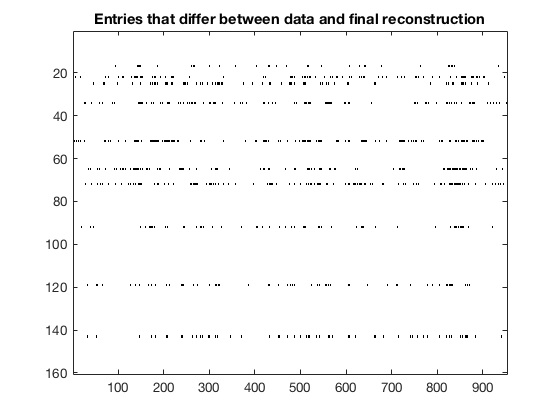

In [3]:

%Building the Reconstructions for each iteration backwards
    R=D; %Let the 
    for k=CGevents:-1:1
        R{k}(included{k})=R{k+1}(1:end-1);
        activ=[cell2mat(R{k+1}(end)'); cell2mat(R{k+1}(end)')].*couplings(k,2:3)';
        recons=(exp((activ))./(2.*cosh(activ))>rand(2,num_samps))*2-1;
        R{k}(MostHi(k,:))={recons(1,:),recons(2,:)};
        %imagesc(cell2mat(R{k}')==cell2mat(D{k}'))
        %find(~ismember(cell2mat(D{1}'),cell2mat(R{1}'),'rows'))
    end
    
    
     figure
     imagesc(cell2mat(R{1}')==C{1})
     title('Entries that differ between data and final reconstruction')
     colormap('gray')


## 4. Compute correlation/covariance matrixes:

### Are the most highly correlated neurons the same in original, coarsened, and reconstructed matrices?

(Need to define "receptive fields" more precisely.)


### Covariance $\mbox{ } cov(s_1,s_2) = \langle s_2 s_2 \rangle - \langle s_1 \rangle  \langle s_2 \rangle $

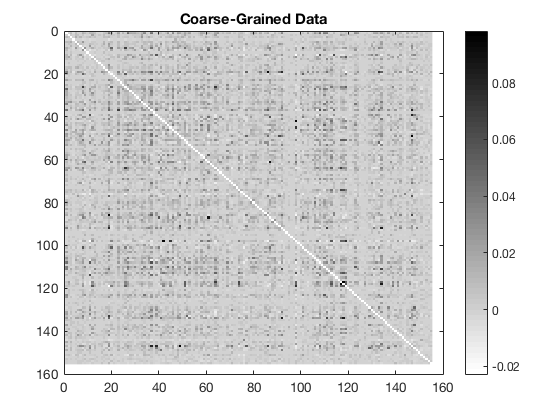

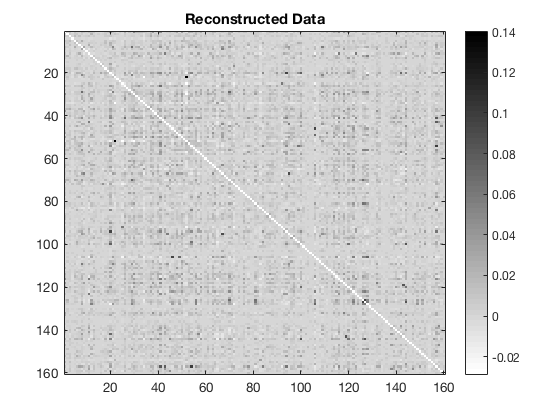

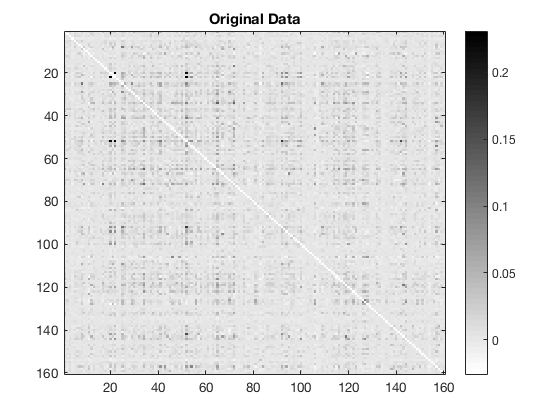

In [15]:
%Compute the covariance matrixes:
        
    %[covC_raw,covC]=cov_matrix(C{1});
    [covDat_raw,covDat]=cov_matrix(cell2mat(D{1}'));
    [covRec_raw,covRec]=cov_matrix(cell2mat(R{1}'));
    [covCG_raw,covCG]=cov_matrix(cell2mat(D{end}'));
    
    %figure,imagesc(covC); title('Original Data Matrix')
    figure,imagesc(covDat); title('Original Data'); colormap(flipud(gray)); colorbar
    figure,imagesc(covRec); title('Reconstructed Data'); colormap(flipud(gray)); colorbar
    figure,imagesc(covCG); title('Coarse-Grained Data'); colormap(flipud(gray)); colorbar
    xlim([0 160]); ylim([0 160])

### Correlation $ \mbox{ } \frac{cov(s_1,s_2)}{\sqrt{var(s_1)var(s_2)}}$

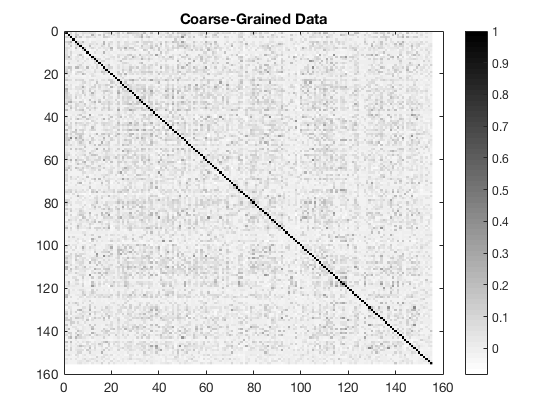

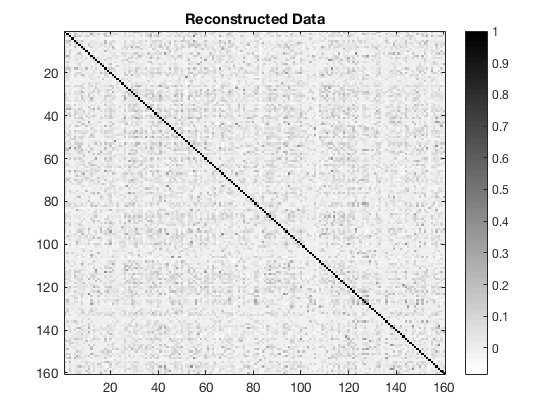

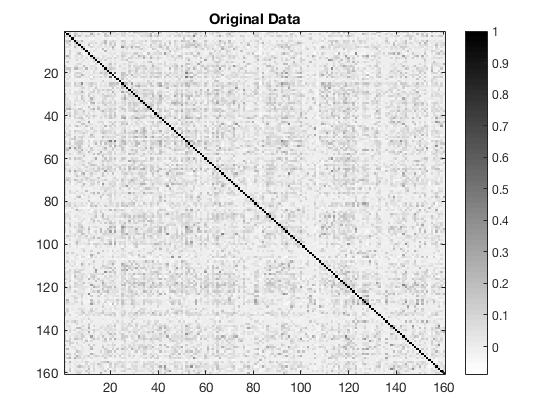

In [14]:
%Compute the Pearson correlation matrices:

    %figure,imagesc(covC); title('Original Data Matrix')
    figure,imagesc(corrcoef(C{1}'));
    title('Original Data'); colormap(flipud(gray)); colorbar
    
    
    %figure,imagesc(covC); title('Original Data Matrix')
    figure,imagesc(corrcoef(cell2mat(R{1}')'));
    title('Reconstructed Data'); colormap(flipud(gray)); colorbar
    
    %figure,imagesc(covC); title('Original Data Matrix')
    figure,imagesc(corrcoef(cell2mat(D{end}')'));
    title('Coarse-Grained Data'); colormap(flipud(gray)); colorbar
    xlim([0 160]); ylim([0 160])

## 5. Sanity check: Which are the most correlated pairs?

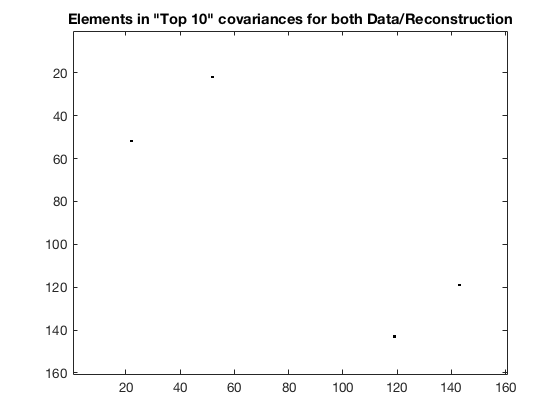

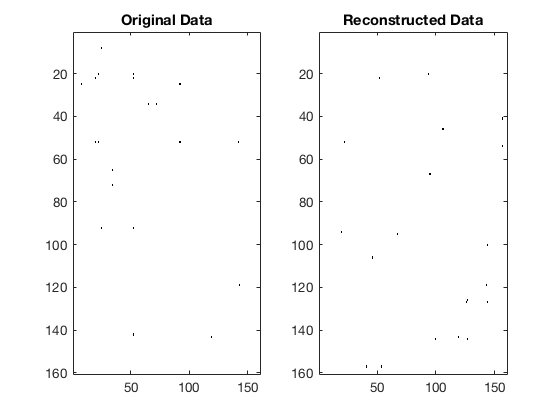

In [29]:
%Find the locations of the most highly correlated in original data, coarse-grained, and final reconstructions, in order.
    
    howmanytop=10;  %Top __ covariance entries (in data/recons)
    
    [covDat_unique indD]=sort(unique(covDat(~isnan(covDat))),'descend');
    covDat_top=covDat_unique(1:howmanytop);
    [rD,cD]=find(ismember(triu(covDat),covDat_top(1:howmanytop)));
    
    [covRec_unique]=sort(unique(covRec(~isnan(covRec))),'descend');
    covRec_top=covRec_unique(1:howmanytop);
    [rR,cR]=find(ismember(triu(covRec),covRec_unique(1:howmanytop)));

    
    %Lists of top entries and locations
    
    for topindsD=1:howmanytop
        topsD(topindsD)=covDat(rD(topindsD),cD(topindsD));
    end
        [topsD,indsD]=sort(topsD','descend');
        rD=rD(indsD); cD=cD(indsD);
    
    for topindsR=1:howmanytop
        topsR(topindsR)=covDat(rR(topindsR),cR(topindsR));
    end
        [topsR,indsR]=sort(topsR','descend');
        rR=rR(indsR); cR=cR(indsR);
    
    
         
    %Side-by-side plot of top cov's for original data vs. recons
    figure
    subplot(1,2,1)
    imagesc(covDat>=covDat_top(end)); colormap(flipud(gray));
    title('Original Data')
    subplot(1,2,2)
    imagesc(covRec>=covRec_top(end)); colormap(flipud(gray));
    title('Reconstructed Data')
    %Should add covCG!!!
    
    
    %figure,imagesc(covRec>=covRec_top(end) == covDat>=covDat_top(end)); colormap(flipud(gray));
    figure,imagesc(((covRec>=covRec_top(end)) + (covDat>=covDat_top(end)))==2); colormap(flipud(gray));
    title('Elements in "Top 10" covariances for both Data/Reconstruction')

## 6. Average reconstruction error for JPD over {(1,1) (1,-1) (-1,1) (-1,-1)}
### View any value of $k$ from $1:CGevents$, or multiple on same plot

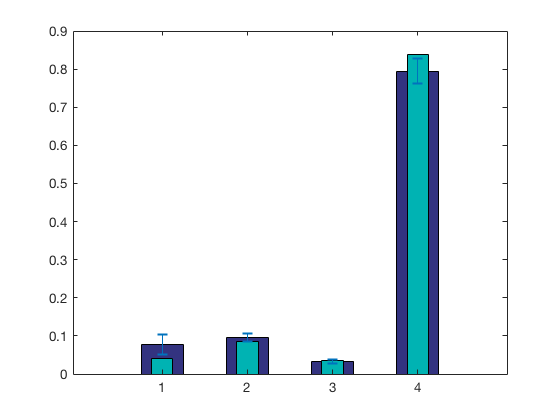

In [49]:
k=1;
%Joint probability distributions w/ average subtractive errors
bar(mean(JPD_compar(1,:,k),3),0.5,'FaceColor',[0.2 0.2 0.5]); hold on; bar(mean(JPD_compar(2,:,k),3),.25,'FaceColor',[0 0.7 0.7])
errorbar(mean(JPD_compar(1,:,k),3),mean(abs(JPD_compar(1,:,:)-JPD_compar(2,:,:)),3),'LineStyle','none','MarkerSize', 20)


%k=2;
%%Joint probability distributions w/ average subtractive errors
%bar(mean(JPD_compar(1,:,k),3),0.5,'FaceColor',[0.2 0.2 0.5]); hold on; bar(mean(JPD_compar(2,:,k),3),.25,'FaceColor',[0 0.7 0.7])
%errorbar(mean(JPD_compar(1,:,k),3),mean(abs(JPD_compar(1,:,:)-JPD_compar(2,:,:)),3),'LineStyle','none','MarkerSize', 20)


%k=3;
%%Joint probability distributions w/ average subtractive errors
%bar(mean(JPD_compar(1,:,k),3),0.5,'FaceColor',[0.2 0.2 0.5]); hold on; bar(mean(JPD_compar(2,:,k),3),.25,'FaceColor',[0 0.7 0.7])
%errorbar(mean(JPD_compar(1,:,k),3),mean(abs(JPD_compar(1,:,:)-JPD_compar(2,:,:)),3),'LineStyle','none','MarkerSize', 20)


## 7a. Sanity check: Are reconstructions cumulative? Which elements replaced?

### The actual "data" matrices containing neuron trajectories:
Showing which entries differ with each backwards iteration

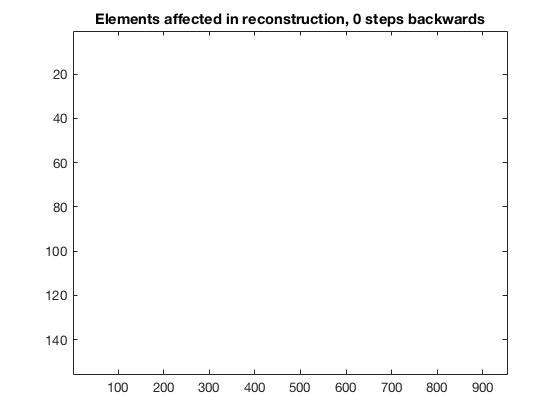

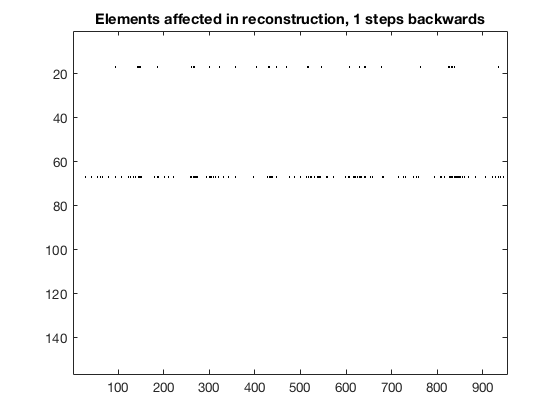

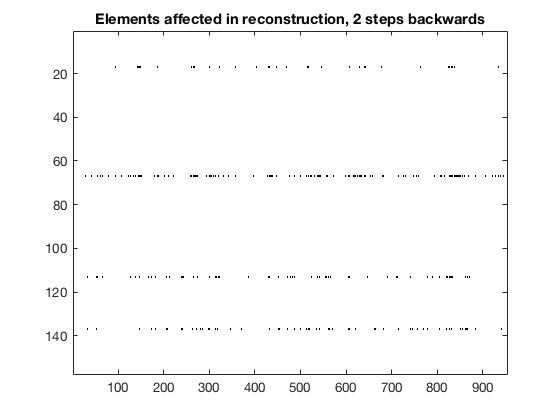

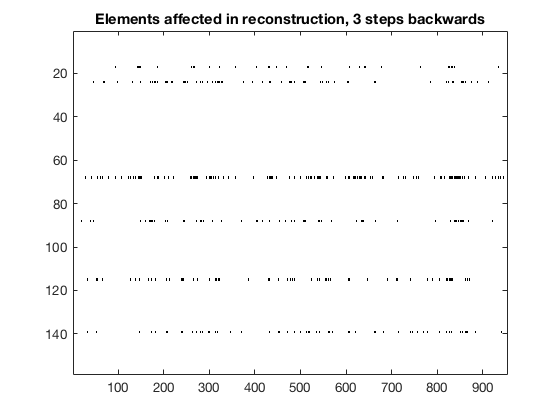

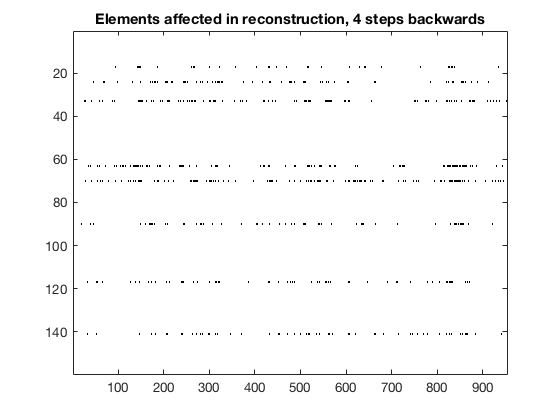

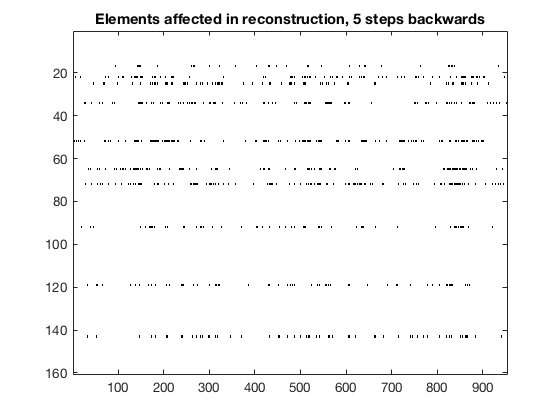

In [38]:


%Reconstructed (different) elements vs data matrix
    %for k=CGevents+1:-1:1
    for k=1:CGevents+1
        figure
        imagesc(cell2mat(R{k}')~=C{k})
        colormap(flipud(gray))
        title(['Elements affected in reconstruction, ' num2str(CGevents+1-k) ' steps backwards'])
    end
        
    

## 7b. Sanity check: Are reconstructions cumulative? Which elements replaced?

### The covariance matrices:
Showing which entries differ with each backwards iteration

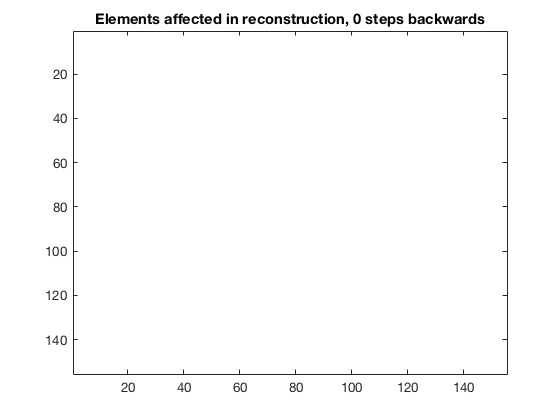

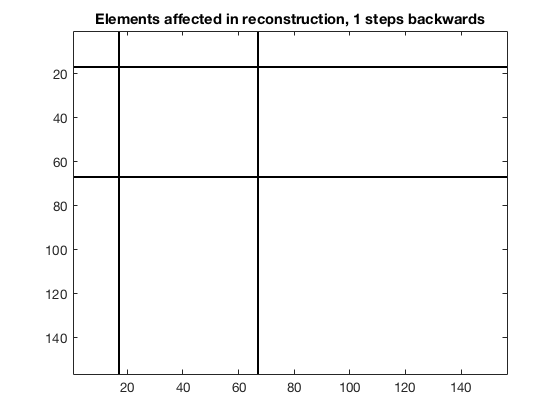

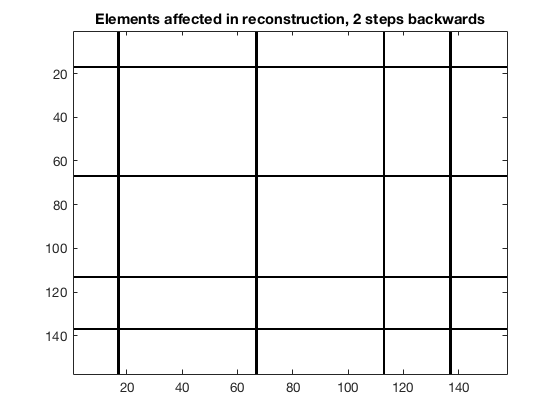

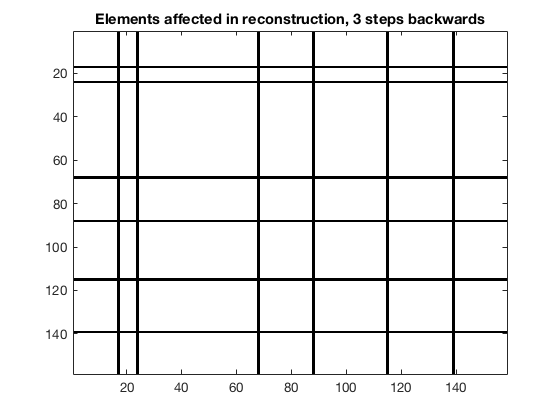

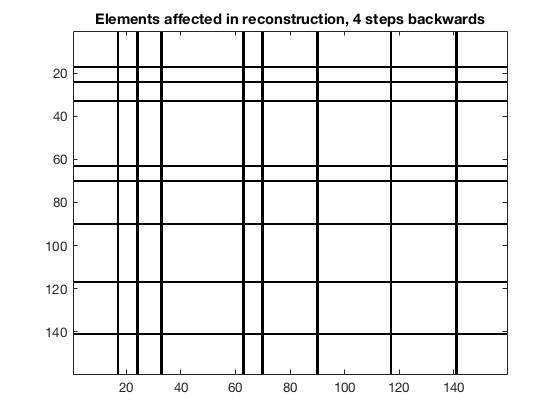

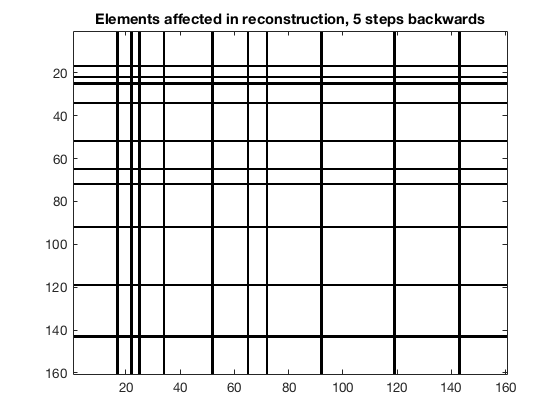

In [37]:

%Reconstructed elements of covariance matrix
    %for k=CGevents+1:-1:1
    for k=1:CGevents+1
        figure
        imagesc(cov_matrix(cell2mat(R{k}'))~=cov_matrix(cell2mat(D{k}')))
        colormap(flipud(gray))
        title(['Elements affected in reconstruction, ' num2str(CGevents+1-k) ' steps backwards'])
    end
        

## 8. Covariance/Correlation Histograms

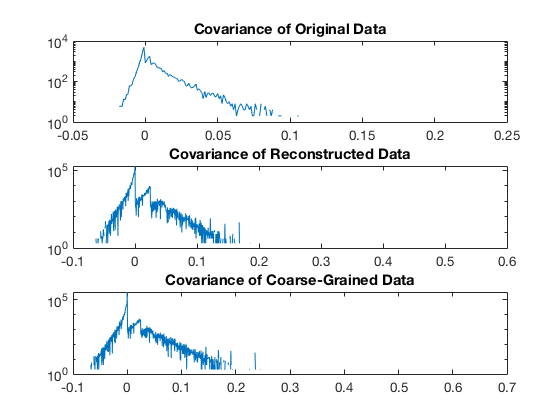

In [52]:

subplot(3,1,1)
u=histogram(covDat);
semilogy(u.BinEdges(1:end-1),u.Values)
title('Covariance of Original Data')

subplot(3,1,2)
v=histogram(cov_matrix(cell2mat(R{1}')')); 
semilogy(v.BinEdges(1:end-1),v.Values)
title('Covariance of Reconstructed Data')

subplot(3,1,3)
w=histogram(cov_matrix(cell2mat(D{1}')')); 
semilogy(w.BinEdges(1:end-1),w.Values)
title('Covariance of Coarse-Grained Data')


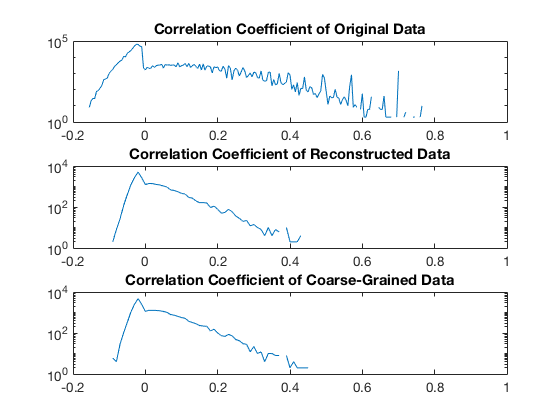

In [53]:

subplot(3,1,1)
u=histogram(corrcoef(C{1}));
semilogy(u.BinEdges(1:end-1),u.Values)
title('Correlation Coefficient of Original Data')

subplot(3,1,2)
v=histogram(corrcoef(cell2mat(R{1}')')); 
semilogy(v.BinEdges(1:end-1),v.Values)
title('Correlation Coefficient of Reconstructed Data')

subplot(3,1,3)
w=histogram(corrcoef(cell2mat(D{1}')')); 
semilogy(w.BinEdges(1:end-1),w.Values)
title('Correlation Coefficient of Coarse-Grained Data')


## Questions

	
* ### What next to quantitatively measure reconstruction quality?

    * 3rd-order stats?
    * Mutual Information
    * Look at Leenoy's work
	
* ### One pair at a time -- still good? How arrange network "layers"?
